In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

from pysr import PySRRegressor

from scipy.optimize import curve_fit

In [2]:
from physical_formula_spinvdisk2 import disks_physical_formula_func as phys_eqn

In [3]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as cons


def Delta(z,Om0=0.279,Ob0=0.046,h=0.7):
    #Bryan & Norman 99
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    x=cosmo.Om(z)-1
    return 18*np.pi**2+82*x-39*x**2

def rho_crit(z,Om0=0.279,Ob0=0.046,h=0.7):
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    return cosmo.critical_density(z).to(u.Msun/u.kpc**3).value

def rho_vir(z,Om0=0.279,Ob0=0.046,h=0.7):
    D=Delta(z,Om0=Om0,Ob0=Ob0,h=h)
    cosmo = FlatLambdaCDM(H0=100*h, Om0=Om0, Ob0=Ob0)
    rho_c = cosmo.critical_density(z).to(u.Msun/u.kpc**3).value
    return D*rho_c

def Rvir_to_Mvir(Rvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return rho_v*4./3.*np.pi*Rvir**3   #Msun

def Mvir_to_Rvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    rho_v = rho_vir(z,Om0=Om0,Ob0=Ob0,h=h)
    return  (Mvir/(rho_v*4./3.*np.pi))**(1./3.)  #kpc

def Mvir_to_Vvir(Mvir,z,Om0=0.279,Ob0=0.046,h=0.7):
    Rvir = Mvir_to_Rvir(Mvir,z,Om0=Om0,Ob0=Ob0,h=h)
    return (np.sqrt(cons.G*Mvir*u.Msun/(Rvir*u.kpc))).to(u.km/u.s)

In [4]:
df_normalized_31 = pd.read_csv('Halo Mass Normalized Dataset w 31 features.csv')

In [5]:
# df here read from the data filtered file from notebook v5
df_log_mass_filtered_v5 = pd.read_csv ('df_log_mass_filtered_v5.csv') 

In [6]:
df_not_normalized = df_log_mass_filtered_v5.loc[: , :]

In [7]:
df_not_normalized

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,...,GalpropLogMvir,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction
0,1.301360e+05,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,...,9.653455,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164,2.710510e-11,1.050790e+08,2.579497e-19
1,5.412750e+05,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,...,11.109008,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143,5.765260e+08,2.713386e+09,2.124748e-01
2,5.801040e+05,4.618540e+07,3.059520e+08,2.233320e+08,0.0,4.726200e-08,2.406350e+08,7.769080e+08,1.583780e+09,1.306340e+07,...,11.068902,5.747273,8.381359,-1.541164,-1.572371,-1.407537,-1.753413,3.521374e+08,1.935917e+09,1.818969e-01
3,1.366780e+06,6.824820e+07,5.498750e+08,3.847350e+08,0.0,1.404620e-07,3.234520e+08,1.352870e+09,1.241640e+09,5.510730e+07,...,11.231941,6.044273,8.509810,-1.372860,-1.403237,-1.358168,-1.585062,6.181232e+08,1.859763e+09,3.323666e-01
4,1.450610e+06,2.448120e+07,1.699390e+08,1.440650e+08,0.0,9.336400e-08,4.903280e+08,4.571360e+08,1.432650e+09,2.915260e+07,...,10.918804,5.286860,8.690487,-1.821570,-1.854860,-1.798652,-2.033912,1.944202e+08,1.627070e+09,1.194910e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35385,1.102630e+05,7.387440e+06,2.422220e+08,2.593020e+08,0.0,1.361980e-08,7.870290e+06,6.859500e+08,1.312080e+08,1.573820e+06,...,10.715352,4.553191,6.895991,-2.352369,-2.379367,-2.390226,-2.564407,2.496094e+08,3.808174e+08,6.554569e-01
35386,1.803450e+05,4.975330e+06,2.204080e+08,3.347660e+08,0.0,2.598400e-08,1.064620e+07,7.534590e+08,1.234320e+08,1.432870e+06,...,10.736769,8.660254,7.027195,-2.525222,-2.544698,-1.952355,-2.736897,2.253833e+08,3.488153e+08,6.461394e-01
35387,1.402810e+05,7.508750e+07,4.174370e+08,2.042310e+08,0.0,2.262000e-08,2.044020e+07,9.392910e+08,1.227350e+08,8.325890e+06,...,10.713967,8.143789,7.310485,-1.290487,-2.013995,-2.423795,-1.589545,4.925245e+08,6.152595e+08,8.005151e-01
35388,1.603850e+05,3.931530e+07,4.901590e+08,2.665320e+08,0.0,2.295740e-08,1.796060e+07,1.086350e+09,1.518140e+08,1.797880e+06,...,10.734885,7.462965,7.254321,-1.608000,-1.677489,-2.290681,-1.822031,5.294743e+08,6.812883e+08,7.771663e-01


#### Add Vvir to Raw Dataset

In [8]:
# Define Halo property Vvir (as it does not exist in the dataset above)
v= Mvir_to_Vvir (np.array(df_not_normalized.loc[:,'HalopropMvir']),0) # has units

In [9]:
v

<Quantity [21.18004688, 64.73085173, 62.76861958, ..., 47.8003278 ,
           48.5739648 , 48.11187183] km / s>

In [10]:
# add Halo property Vvir
df_not_normalized.loc[:, 'HalopropVvir']=v.value 

In [11]:
df_not_normalized

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,...,HalopropLogMhot,GalpropLogMbulge,GalpropLogSfr,GalpropLogSfrave100myr,GalpropLogSfrave1gyr,GalpropLogSfrave20myr,Galprop_neutral_H_mass,Galprop_baryon_mass,Galprop_gas_fraction,HalopropVvir
0,1.301360e+05,0.000000e+00,2.710510e-11,2.283460e+05,0.0,3.504660e-09,7.260470e+07,3.082220e+05,1.050790e+08,1.404410e+06,...,9.977905,7.860965,-3.395986,-3.426001,-3.339338,-3.608164,2.710510e-11,1.050790e+08,2.579497e-19,21.180047
1,5.412750e+05,1.455160e+08,4.310100e+08,2.505300e+08,0.0,4.201900e-08,2.312560e+08,1.111490e+09,2.136860e+09,4.105360e+07,...,5.930248,8.364093,-0.994489,-1.012659,-0.833138,-1.206143,5.765260e+08,2.713386e+09,2.124748e-01,64.730852
2,5.801040e+05,4.618540e+07,3.059520e+08,2.233320e+08,0.0,4.726200e-08,2.406350e+08,7.769080e+08,1.583780e+09,1.306340e+07,...,5.747273,8.381359,-1.541164,-1.572371,-1.407537,-1.753413,3.521374e+08,1.935917e+09,1.818969e-01,62.768620
3,1.366780e+06,6.824820e+07,5.498750e+08,3.847350e+08,0.0,1.404620e-07,3.234520e+08,1.352870e+09,1.241640e+09,5.510730e+07,...,6.044273,8.509810,-1.372860,-1.403237,-1.358168,-1.585062,6.181232e+08,1.859763e+09,3.323666e-01,71.135923
4,1.450610e+06,2.448120e+07,1.699390e+08,1.440650e+08,0.0,9.336400e-08,4.903280e+08,4.571360e+08,1.432650e+09,2.915260e+07,...,5.286860,8.690487,-1.821570,-1.854860,-1.798652,-2.033912,1.944202e+08,1.627070e+09,1.194910e-01,55.938390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35385,1.102630e+05,7.387440e+06,2.422220e+08,2.593020e+08,0.0,1.361980e-08,7.870290e+06,6.859500e+08,1.312080e+08,1.573820e+06,...,4.553191,6.895991,-2.352369,-2.379367,-2.390226,-2.564407,2.496094e+08,3.808174e+08,6.554569e-01,47.851193
35386,1.803450e+05,4.975330e+06,2.204080e+08,3.347660e+08,0.0,2.598400e-08,1.064620e+07,7.534590e+08,1.234320e+08,1.432870e+06,...,8.660254,7.027195,-2.525222,-2.544698,-1.952355,-2.736897,2.253833e+08,3.488153e+08,6.461394e-01,48.644280
35387,1.402810e+05,7.508750e+07,4.174370e+08,2.042310e+08,0.0,2.262000e-08,2.044020e+07,9.392910e+08,1.227350e+08,8.325890e+06,...,8.143789,7.310485,-1.290487,-2.013995,-2.423795,-1.589545,4.925245e+08,6.152595e+08,8.005151e-01,47.800328
35388,1.603850e+05,3.931530e+07,4.901590e+08,2.665320e+08,0.0,2.295740e-08,1.796060e+07,1.086350e+09,1.518140e+08,1.797880e+06,...,7.462965,7.254321,-1.608000,-1.677489,-2.290681,-1.822031,5.294743e+08,6.812883e+08,7.771663e-01,48.573965


#### Add BulgeMstar_ratio to the normalized and the raw datasets to compare with each other (check consistency)

In [12]:
df_not_normalized.loc[:, 'BulgeMstar_ratio'] = df_not_normalized.loc[:,'GalpropMbulge']/df_not_normalized.loc[:, 'GalpropMstar']

In [13]:
df_normalized_31.loc[:, 'BulgeMstar_ratio'] = df_normalized_31.loc[:,'GalpropNormMbulge']/df_normalized_31.loc[:, 'GalpropNormMstar']

In [14]:
df_not_normalized.loc[:, 'GalpropMdisk'] = df_not_normalized.loc[:, 'GalpropMstar'] - df_not_normalized.loc[:, 'GalpropMbulge']

In [15]:
df_normalized_31.loc[:, 'GalpropNormMdisk'] = df_normalized_31.loc[:, 'GalpropNormMstar'] - df_normalized_31.loc[:, 'GalpropNormMbulge']

In [16]:
df_not_normalized.loc[:, 'DiskMstar_ratio']  = df_not_normalized.loc[:, 'GalpropMdisk']/df_not_normalized.loc[:, 'GalpropMstar']

In [17]:
df_normalized_31.loc[:, 'DiskMstar_ratio']  = df_normalized_31.loc[:, 'GalpropNormMdisk']/df_normalized_31.loc[:, 'GalpropNormMstar']

In [18]:
df_not_normalized.shape

(35390, 70)

In [19]:
df_normalized_31.shape

(35390, 35)

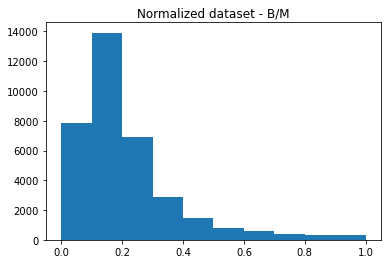

In [20]:
plt.hist(df_normalized_31['BulgeMstar_ratio'])
plt.title('Normalized dataset - B/M')
plt.show()

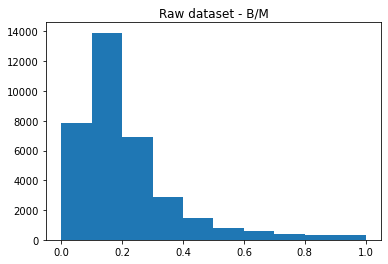

In [21]:
plt.hist(df_not_normalized['BulgeMstar_ratio'])
plt.title('Raw dataset - B/M')
plt.show()

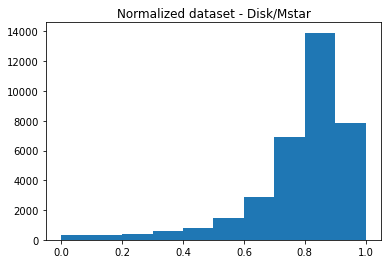

In [22]:
plt.hist(df_normalized_31['DiskMstar_ratio'])
plt.title('Normalized dataset - Disk/Mstar')
plt.show()

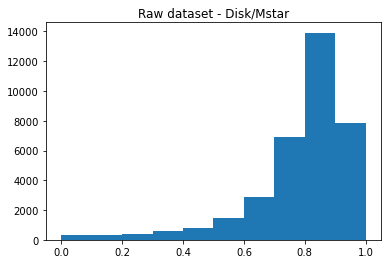

In [23]:
plt.hist(df_not_normalized['DiskMstar_ratio'])
plt.title('Raw dataset - Disk/Mstar')
plt.show()

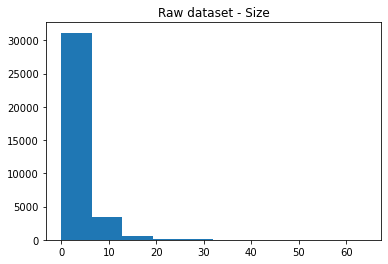

In [24]:
plt.hist(df_not_normalized['GalpropHalfRadius'])
plt.title('Raw dataset - Size')
plt.show()

#### Define the 6 morphology groups by increasing Mbulge/Mstar ratio

In [131]:
# 7,865 galaxies in df_1
df_1 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']<=0.10] 
df_1_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']<=0.10] 


# 13,921 galaxies in df_2
df_2 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.10) & (df_normalized_31.BulgeMstar_ratio <= 0.20)] 
df_2_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.10) & (df_not_normalized.BulgeMstar_ratio <= 0.20)] 


# 6,880 galaxies in df_3
df_3 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.20) & (df_normalized_31.BulgeMstar_ratio <= 0.30)] 
df_3_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.20) & (df_not_normalized.BulgeMstar_ratio <= 0.30)] 


# 2,858 galaxies in df_4
df_4 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.30) & (df_normalized_31.BulgeMstar_ratio <= 0.40)] 
df_4_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.30) & (df_not_normalized.BulgeMstar_ratio <= 0.40)] 


# 1,444 galaxies in df_5
df_5 = df_normalized_31.loc[(df_normalized_31.BulgeMstar_ratio > 0.40) & (df_normalized_31.BulgeMstar_ratio <= 0.50)] 
df_5_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.40) & (df_not_normalized.BulgeMstar_ratio <= 0.50)] 


# 2,422 galaxies in df_5
df_6 = df_normalized_31.loc[df_normalized_31.loc[:, 'BulgeMstar_ratio']>0.50] 
df_6_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']>0.50] 

# Combined morphologies 1 to 4 in order to fit one physical model to all of them; 31,524 galaxies in the 1-4 morphologies
df_14 = df_normalized_31.loc[df_normalized_31.BulgeMstar_ratio <= 0.40] #normalized
df_14_raw = df_not_normalized.loc[df_not_normalized.BulgeMstar_ratio <= 0.40] 

# Ellipticals only
df_56 = df_normalized_31.loc[df_normalized_31.BulgeMstar_ratio > 0.40] #normalized
df_56_raw = df_not_normalized.loc[df_not_normalized.BulgeMstar_ratio > 0.40]




In [26]:
df_14.shape

(31524, 35)

In [27]:
df_14_raw.shape

(31524, 70)

### Groups 5 and 6 analysis

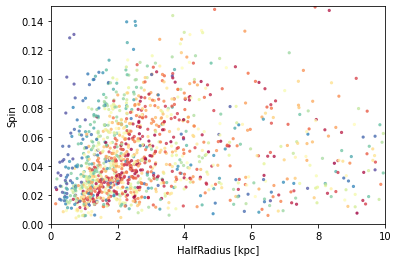

In [28]:
plt.scatter(df_5_raw.loc[:, 'GalpropHalfRadius'], df_5_raw.loc[:, 'HalopropSpin'], 
             c = df_5_raw.loc[:,'BulgeMstar_ratio'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7)
plt.xlabel('HalfRadius [kpc]')
plt.ylabel('Spin')
plt.xlim(0,10)
plt.ylim(0, 0.15)
plt.show()

# Conclusion: Most galaxies in Group 5 are small size, 0-4 kpc;
# looking at histogram below, 1000 out of ~1,4000 galaxies in this group have sizes between 0-4 kpc

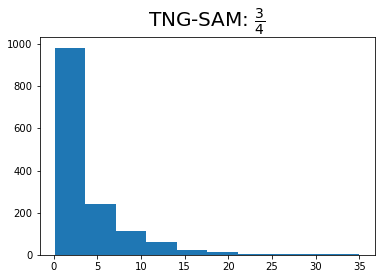

In [29]:
plt.hist(df_5_raw.loc[:, 'GalpropHalfRadius'])
plt.title(r'TNG-SAM: $\frac{3}{4}$', fontsize=20)
plt.show()

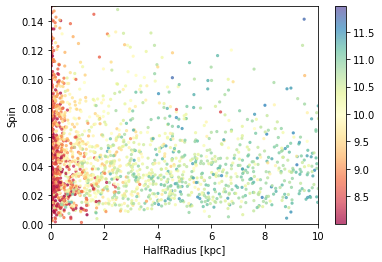

In [30]:
plt.scatter(df_6_raw.loc[:, 'GalpropHalfRadius'], df_6_raw.loc[:, 'HalopropSpin'], 
             c = np.log10(df_6_raw.loc[:,'GalpropMstar']),  cmap='Spectral',
            s=20, marker='.', alpha=0.7)
plt.xlabel('HalfRadius [kpc]')
plt.ylabel('Spin')
plt.xlim(0,10)
plt.ylim(0, 0.15)
plt.colorbar()
plt.show()

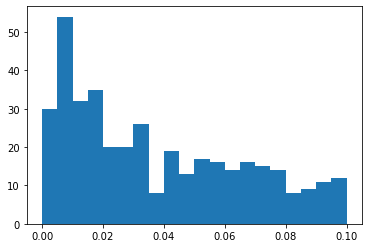

In [31]:
plt.hist(df_6_raw.loc[:, 'GalpropHalfRadius'], range=[0,0.1],bins=20)
plt.show()

We learn from these two plots that ~700 galaxies of Group 6 have Mstar=0 and should be removed from the df.
1) What are the most important features of this group after we remove Mstar=0?

2) Can we deduce a physical model for this group by simly looking at simple relations between the most important features?

## <font color='darkred'> Check the relation of NormVdik=Vdisk/Vvir vs C_nfw

(array([20617.,  6881.,  2625.,  1477.,   857.,   627.,   469.,   375.,
          308.,   229.,   174.,   124.,   110.,    95.,    75.,    66.,
           51.,    50.,    35.,    25.]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  ]),
 <BarContainer object of 20 artists>)

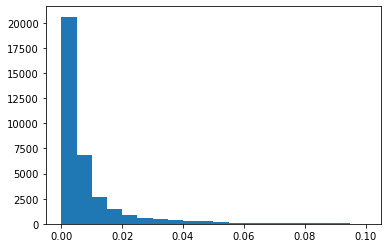

In [32]:
plt.hist(df_normalized_31.loc[:,'GalpropNormMstar'], range=[0,0.1],bins=20)

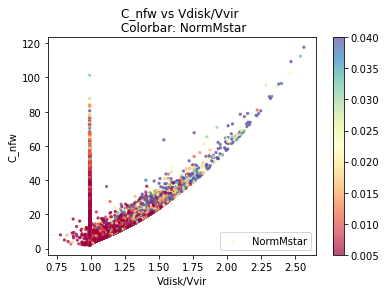

In [33]:
plt.scatter(df_normalized_31.loc[:, 'GalpropNormVdisk'], df_normalized_31.loc[:, 'HalopropC_nfw'],
            c = df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormMstar', vmin=0.005, vmax=0.04)
plt.xlabel('Vdisk/Vvir')
plt.ylabel('C_nfw')
plt.title('C_nfw vs Vdisk/Vvir \n Colorbar: NormMstar')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisk_colorbar_NormMstar.jpeg', dpi=500)
plt.show()

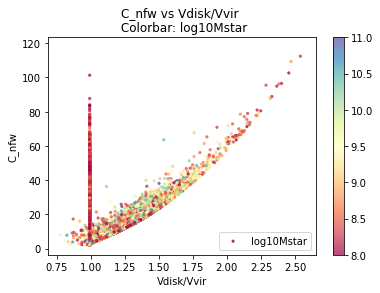

In [34]:
plt.scatter(df_normalized_31.loc[:, 'GalpropNormVdisk'], df_normalized_31.loc[:, 'HalopropC_nfw'],
            c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
#             c = df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='log10Mstar', vmin=8.0, vmax=11.0)
plt.xlabel('Vdisk/Vvir')
plt.ylabel('C_nfw')
plt.title('C_nfw vs Vdisk/Vvir \n Colorbar: log10Mstar')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisk.jpeg', dpi=500)
plt.show()

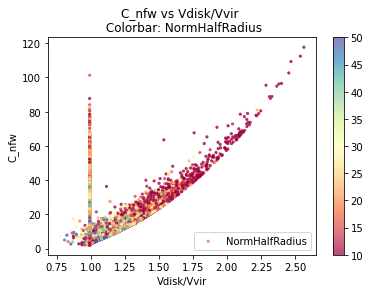

In [35]:
plt.scatter(df_normalized_31.loc[:, 'GalpropNormVdisk'], df_normalized_31.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
plt.xlabel('Vdisk/Vvir')
plt.ylabel('C_nfw')
plt.title('C_nfw vs Vdisk/Vvir \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisk_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

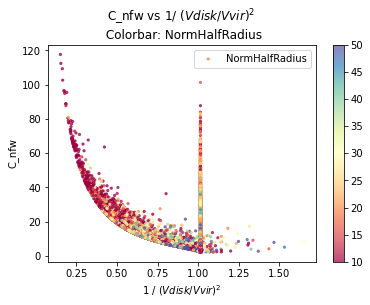

In [36]:
plt.scatter((1/(df_normalized_31.loc[:, 'GalpropNormVdisk'])**2), df_normalized_31.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'1 / $(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs 1/ $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='upper right')
plt.colorbar()
# plt.savefig('C_nfw_vs_inverseNormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

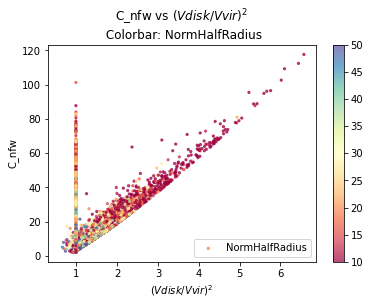

In [37]:
plt.scatter((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, df_normalized_31.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

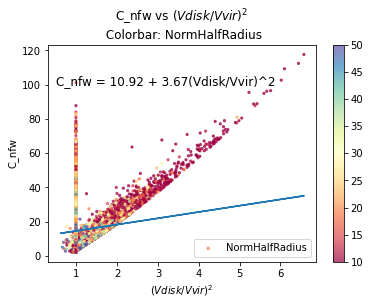

In [38]:
#find line of best fit
a1, b1 = np.polyfit((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, df_normalized_31.loc[:, 'HalopropC_nfw'], 1)


plt.scatter((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, df_normalized_31.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()

#add line of best fit to plot
# plt.plot(df_normalized_31.loc[:, 'HalopropC_nfw'], a1*((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2)+b1) 
plt.plot((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, a1*((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2)+b1 )
#add fitted regression equation to plot
plt.text(0.5, 100, 'C_nfw = ' + '{:.2f}'.format(b1) + ' + {:.2f}'.format(a1) + '(Vdisk/Vvir)^2', size=12)


# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

In [39]:
# df excluding all normvdisk <=1.0
df_normalized_wovdisk1 = df_normalized_31.loc[df_normalized_31.GalpropNormVdisk > 1.0]

In [40]:
df_normalized_31.GalpropNormVdisk > 1.0

0        False
1         True
2        False
3        False
4        False
         ...  
35385    False
35386    False
35387     True
35388     True
35389    False
Name: GalpropNormVdisk, Length: 35390, dtype: bool

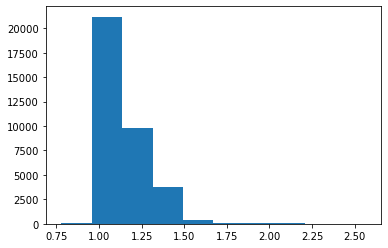

In [41]:
plt.hist(df_normalized_31['GalpropNormVdisk'])
plt.show()

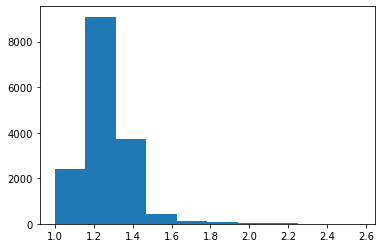

In [42]:
plt.hist(df_normalized_wovdisk1['GalpropNormVdisk'])
plt.show()

In [43]:
# 15,933 (out of 35,390; that is 45%) galaxies have normvdisk>1.0
df_normalized_wovdisk1.shape

(15933, 35)

In [44]:
df_normalized_31.shape

(35390, 35)

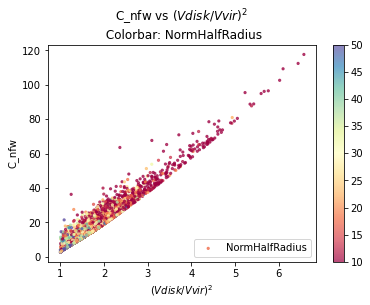

In [45]:
plt.scatter((df_normalized_wovdisk1['GalpropNormVdisk'])**2, df_normalized_wovdisk1.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_wovdisk1.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

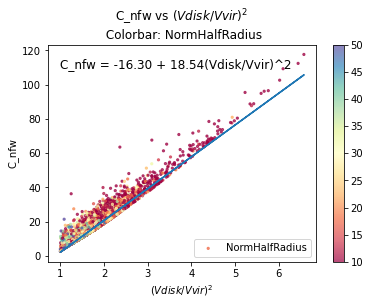

In [46]:
#find line of best fit
a1, b1 = np.polyfit((df_normalized_wovdisk1.loc[:, 'GalpropNormVdisk'])**2, df_normalized_wovdisk1.loc[:, 'HalopropC_nfw'], 1)


plt.scatter((df_normalized_wovdisk1.loc[:, 'GalpropNormVdisk'])**2, df_normalized_wovdisk1.loc[:, 'HalopropC_nfw'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_wovdisk1.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('C_nfw')
plt.title(r'C_nfw vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()

#add line of best fit to plot
# plt.plot(df_normalized_31.loc[:, 'HalopropC_nfw'], a1*((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2)+b1) 
plt.plot((df_normalized_wovdisk1.loc[:, 'GalpropNormVdisk'])**2, a1*((df_normalized_wovdisk1.loc[:, 'GalpropNormVdisk'])**2)+b1 )
#add fitted regression equation to plot
plt.text(1.0, 110, 'C_nfw = ' + '{:.2f}'.format(b1) + ' + {:.2f}'.format(a1) + '(Vdisk/Vvir)^2', size=12)


# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius_wovdisk1.jpeg', dpi=500)
plt.show()

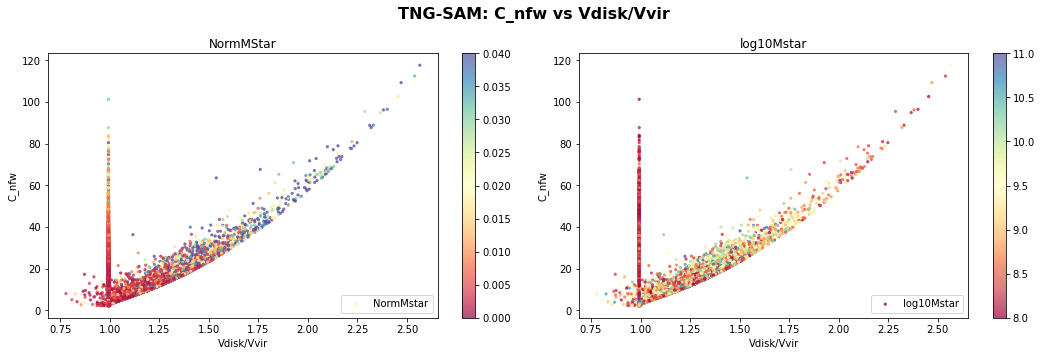

In [20]:
fig_cnfw, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig_cnfw.suptitle('TNG-SAM: C_nfw vs Vdisk/Vvir ', fontsize=16, fontweight='bold')

fig1 = ax1.scatter(df_normalized_31.loc[:, 'GalpropNormVdisk'], df_normalized_31.loc[:, 'HalopropC_nfw'],
            c = df_normalized_31.loc[:,'GalpropNormMstar'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormMstar', vmin=0.0, vmax=0.04)
ax1.set_xlabel('Vdisk/Vvir')
ax1.set_ylabel('C_nfw')
ax1.set_title('NormMStar')
ax1.legend(loc='lower right')
fig_cnfw.colorbar(fig1, ax=ax1)

fig2 = ax2.scatter(df_not_normalized.loc[:, 'GalpropVdisk']/df_not_normalized.loc[:, 'HalopropVvir'],
                   df_not_normalized.loc[:, 'HalopropC_nfw'],
            c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='log10Mstar', vmin=8.0, vmax=11.0)
ax2.set_xlabel('Vdisk/Vvir')
ax2.set_ylabel('C_nfw')
ax2.set_title('log10Mstar')
ax2.legend(loc='lower right')
fig_cnfw.colorbar(fig2, ax=ax2)

fig_cnfw.tight_layout()

plt.show()

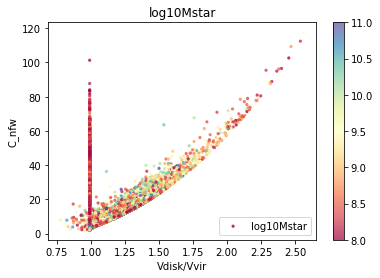

In [48]:
plt.scatter(df_not_normalized.loc[:, 'GalpropVdisk']/df_not_normalized.loc[:, 'HalopropVvir'],
                   df_not_normalized.loc[:, 'HalopropC_nfw'],
            c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='log10Mstar', vmin=8.0, vmax=11.0)
plt.xlabel('Vdisk/Vvir')
plt.ylabel('C_nfw')
plt.title('log10Mstar')
plt.legend(loc='lower right')
plt.colorbar()
plt.show()

In [49]:
def f_c(c):
    return 2.0 / 3.0 + (c / 21.5)**0.7

In [50]:
df_normalized_31.loc[:, 'f_c(c)'] = df_normalized_31.apply(lambda x: f_c(c=x['HalopropC_nfw']), axis=1)

In [51]:
df_normalized_31.shape

(35390, 36)

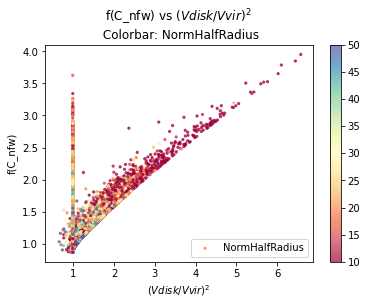

In [52]:
plt.scatter((df_normalized_31.loc[:, 'GalpropNormVdisk'])**2, df_normalized_31.loc[:, 'f_c(c)'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'$(Vdisk/Vvir)^{2}$')
plt.ylabel('f(C_nfw)')
plt.title(r'f(C_nfw) vs $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('C_nfw_vs_NormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

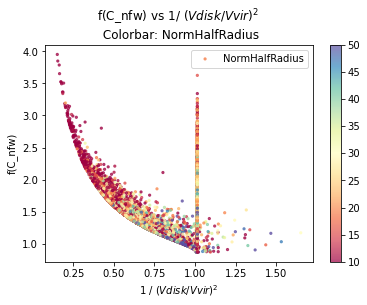

In [53]:
plt.scatter((1/(df_normalized_31.loc[:, 'GalpropNormVdisk'])**2), df_normalized_31.loc[:, 'f_c(c)'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r'1 / $(Vdisk/Vvir)^{2}$')
plt.ylabel('f(C_nfw)')
plt.title(r'f(C_nfw) vs 1/ $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='upper right')
plt.colorbar()
# plt.savefig('funcC_nfw_vs_inverseNormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

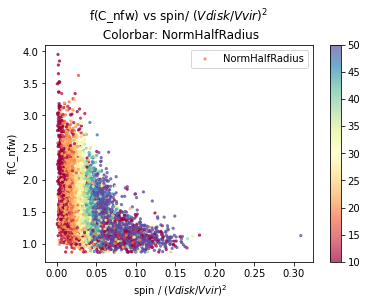

In [54]:
plt.scatter((df_normalized_31.loc[:,'HalopropSpin']/(df_normalized_31.loc[:, 'GalpropNormVdisk'])**2), df_normalized_31.loc[:, 'f_c(c)'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlabel(r' spin / $(Vdisk/Vvir)^{2}$')
plt.ylabel('f(C_nfw)')
plt.title(r'f(C_nfw) vs spin/ $(Vdisk/Vvir)^{2}$' + ' \n Colorbar: NormHalfRadius')
plt.legend(loc='upper right')
plt.colorbar()
# plt.savefig('funcC_nfw_vs_spinNormVdisksquared_colorbar_NormHalfRadius.jpeg', dpi=500)
plt.show()

## <font color='darkred'> Correlations between Mbulge and Mstar

#### Correlation between Mbulge and Mstar - not normalized

In [55]:
# Pearson
np.corrcoef(df_not_normalized.loc[:, 'GalpropMbulge'], df_not_normalized.loc[:, 'GalpropMstar'])

array([[1.        , 0.90950382],
       [0.90950382, 1.        ]])

In [56]:
# Spearman
round(stats.spearmanr(df_not_normalized.loc[:, 'GalpropMbulge'], df_not_normalized.loc[:, 'GalpropMstar'])[0], 2)

0.91

#### Correlation between Mbulge and Mstar - normalized

In [57]:
# Pearson
np.corrcoef(df_normalized_31.loc[:, 'GalpropNormMbulge'], df_normalized_31.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.98605335],
       [0.98605335, 1.        ]])

In [58]:
# Spearman
round(stats.spearmanr(df_normalized_31.loc[:, 'GalpropNormMbulge'], df_normalized_31.loc[:, 'GalpropNormMstar'])[0], 2)

0.76

#### Correlation between Mbulge and Mstar - log10

In [59]:
# Pearson
np.corrcoef(np.log10(df_not_normalized.loc[:, 'GalpropMbulge']), np.log10(df_not_normalized.loc[:, 'GalpropMstar']))

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/numpy/lib/function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


array([[nan, nan],
       [nan,  1.]])

In [60]:
# Spearman
spear_log = round(stats.spearmanr(np.log10(df_not_normalized.loc[:, 'GalpropMbulge']), np.log10(df_not_normalized.loc[:, 'GalpropMstar']))[0], 2)

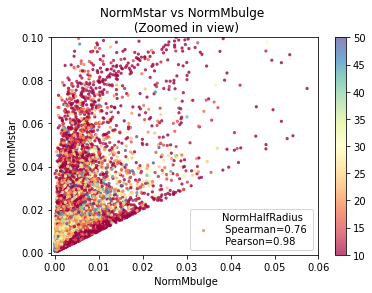

In [61]:
plt.scatter(df_normalized_31.loc[:,'GalpropNormMbulge'], df_normalized_31.loc[:, 'GalpropNormMstar'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_normalized_31.loc[:,'GalpropNormHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='NormHalfRadius \n Spearman=0.76 \n Pearson=0.98', vmin=10.0, vmax=50)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlim(-0.001, 0.06)
plt.ylim(-0.001, 0.1)
plt.xlabel(' NormMbulge')
plt.ylabel('NormMstar')
plt.title('NormMstar vs NormMbulge' + ' \n (Zoomed in view)')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('NormMstar_NormMbulge_zoomedin.jpeg', dpi=500)
plt.show()

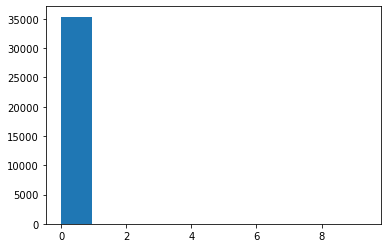

In [62]:
plt.hist(df_normalized_31.loc[:,'GalpropNormMbulge'])
plt.show()

In [166]:
def hist2dplot(axis,x,y,fill=True,**kwargs):
    
    h,xed,yed=np.histogram2d(x,y)
    
    
    h=np.transpose(h)
    total=h.sum()
    h=h/total
    hflat=np.sort(np.reshape(h,-1)) #makes 1D and sorted 
    csum=np.cumsum(hflat)
    values=1.0-np.array([0.9973,0.9545,0.6827,0.0])
    
    levels=[]
    
    for val in values:
        idx = (np.abs(csum - val)).argmin()
        levels.append(hflat[idx])

    print(levels)
    if fill:
#         colors=['#f7f7f7','#cccccc','#969696','#525252'] #gray
        colors=['#ffffcc','#c2e699','#78c679','#238443'] #green 
        axis.contourf(h,levels,colors=colors,extent=[xed[0],xed[-1],yed[0],yed[-1]])
    else:
        colors=['#fdcc8a','#fc8d59','#d7301f'] 
        axis.contour(h,levels,colors=colors,extent=[xed[0],xed[-1],yed[0],yed[-1]])
    
    

[0.0007064142413111048, 0.011302627860977677, 0.06580955072054252, 0.2789771121785815]


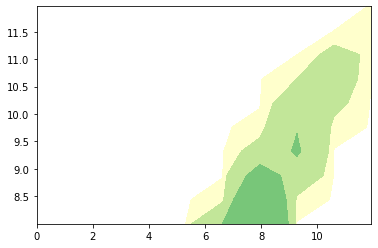

In [168]:
fig2, ax =plt.subplots()

hist2dplot(axis = ax,x = df_not_normalized.loc[:,'GalpropLogMbulge'], y =  df_not_normalized.loc[:, 'GalpropLogMstar'], fill=True, bins=100


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


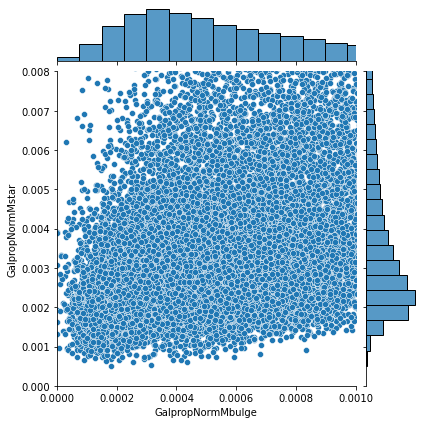

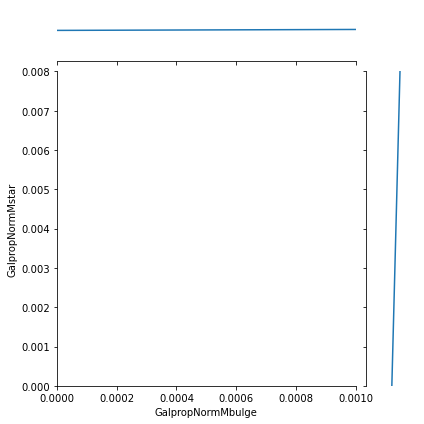

In [65]:
# library & dataset
import seaborn as sns
# df = sns.load_dataset('iris')
 
# Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
sns.jointplot(x=df_normalized_31['GalpropNormMbulge'], y=df_normalized_31['GalpropNormMstar'], 
              kind='scatter', xlim=(0.0,0.001), ylim=(0.0,0.008))

sns.jointplot(x=df_normalized_31['GalpropNormMbulge'], y=df_normalized_31['GalpropNormMstar'], 
              kind='kde', xlim=(0.0,0.001), ylim=(0.0,0.008))

plt.show()

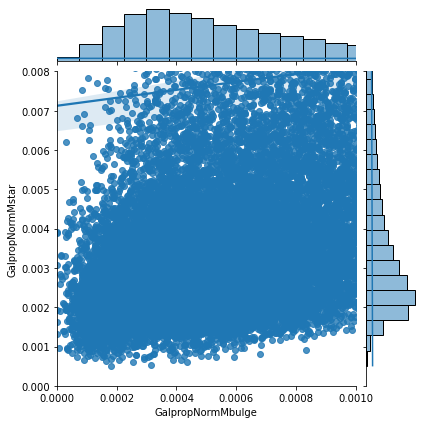

In [66]:
sns.jointplot(x=df_normalized_31['GalpropNormMbulge'], y=df_normalized_31['GalpropNormMstar'], 
              kind='reg', xlim=(0.0,0.001), ylim=(0.0,0.008))

plt.show()

In [66]:
dfnew = df_normalized_31[(df_normalized_31.GalpropNormMbulge < 0.06) &  (df_normalized_31.GalpropNormMstar < 0.06)]

In [67]:
dfnew.shape

(34763, 36)

In [68]:
df_normalized_31.GalpropNormMbulge.describe()

count    35390.000000
mean         0.002621
std          0.065940
min          0.000000
25%          0.000391
50%          0.000722
75%          0.001619
max          9.356540
Name: GalpropNormMbulge, dtype: float64

In [69]:
df_normalized_31.GalpropNormMstar.describe()

count    35390.000000
mean         0.009779
std          0.067687
min          0.000513
25%          0.002495
50%          0.004065
75%          0.008808
max          9.375894
Name: GalpropNormMstar, dtype: float64

### Mbulge Mstar correlations with and without outliers

dfnew1 to learn how many galaxies have a ratio of Mstar/Mvir > 0.2 and are therefore not physical
answer: 22 galaxies, out of 35,390

In [70]:
dfnew1 = df_not_normalized.loc[:, 'GalpropMstar']/df_not_normalized.loc[:, 'GalpropMvir']

In [71]:
df_not_normalized.loc[26174, 'GalpropMvir']

17050500869.750977

In [72]:
df_not_normalized.loc[26174, 'GalpropMstar']

28871400833.129883

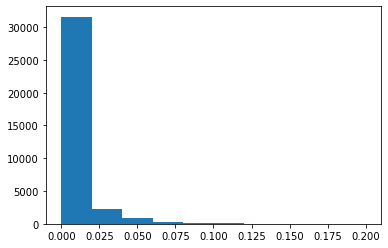

In [73]:
plt.hist(dfnew1, range=(0.0, 0.2))
plt.show()

In [74]:
dfnew1[dfnew1 > 0.2].shape

(22,)

removing non-physical galaxies from the RAW dataset and checking the correlations

In [75]:
dfnew2 = df_not_normalized.loc[: , :]

In [76]:
dfnew2.loc[: , 'MstarMvir_ratio'] = dfnew2.loc[:, 'GalpropMstar']/dfnew2.loc[:, 'GalpropMvir']

In [77]:
dfnew2 = dfnew2[dfnew2.MstarMvir_ratio < 0.2]

In [78]:
dfnew2.shape

(35368, 71)

In [79]:
# Pearson
np.corrcoef(dfnew2.loc[:, 'GalpropMbulge'], dfnew2.loc[:, 'GalpropMstar'])

array([[1.        , 0.90932868],
       [0.90932868, 1.        ]])

In [80]:
# Spearman
round(stats.spearmanr(dfnew2.loc[:, 'GalpropMbulge'], dfnew2.loc[:, 'GalpropMstar'])[0], 2)

0.91

removing the non-physical galaxies from the NORMALIZED dataset and checking the correlations

In [81]:
dfnew3 = df_normalized_31.loc[: , :]

In [82]:
dfnew3 = dfnew3[dfnew3.GalpropNormMstar < 0.2]

In [83]:
dfnew3.shape

(35368, 36)

In [84]:
# Pearson
np.corrcoef(dfnew3.loc[:, 'GalpropNormMbulge'], dfnew3.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.71181994],
       [0.71181994, 1.        ]])

In [85]:
# Spearman
round(stats.spearmanr(dfnew3.loc[:, 'GalpropNormMbulge'], dfnew3.loc[:, 'GalpropNormMstar'])[0], 2)

0.76

#### Conclusion: the Pearson correlation in the normalized dataset goes from 0.98 to 0.71 after removing the 22 non-physical galaxies. The Spearman correlation remains the same 0.76 in both cases.
#### Therefore, the high Pearson correlation between Mbulge and Mstar is not physical as it is driven by the 22 outlier galaxies.

--------

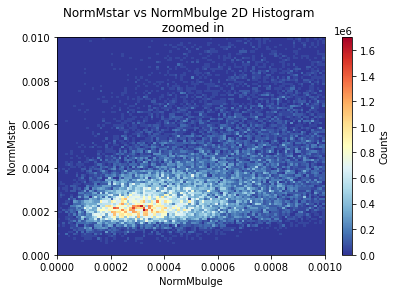

In [86]:
# Figure using the Matplotlib hist2d

plt.hist2d(dfnew3['GalpropNormMbulge'], dfnew3['GalpropNormMstar'],  bins = 100,
             cmap='RdYlBu_r' , density=True, range=[[0.0,0.001],[0.0,0.01]])
plt.title('NormMstar vs NormMbulge 2D Histogram \n zoomed in')
plt.ylabel('NormMstar')
plt.xlabel('NormMbulge')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
# plt.savefig("NormMstar_vs_NormMbulge_2D_Histogram_zoomed_in.jpeg", dpi=500)
plt.show()

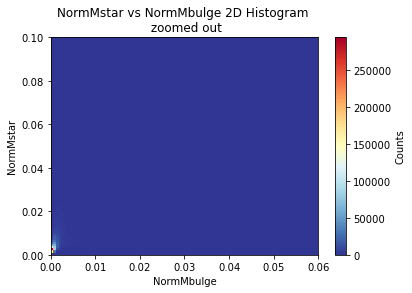

In [87]:
# Figure using the Matplotlib hist2d

plt.hist2d(df_normalized_31['GalpropNormMbulge'], df_normalized_31['GalpropNormMstar'],  bins = 100,
             cmap='RdYlBu_r', range=[[0.0,0.06],[0.0,0.1]], density=True)
plt.title('NormMstar vs NormMbulge 2D Histogram \n zoomed out')
plt.ylabel('NormMstar')
plt.xlabel('NormMbulge')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
# plt.savefig("NormMstar_vs_NormMbulge_2D_Histogram_zoomed_out.jpeg", dpi=500)
plt.show()

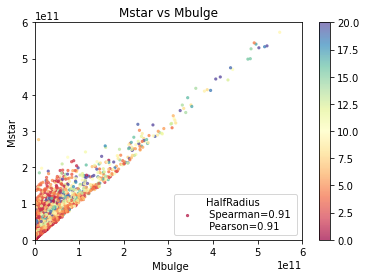

In [88]:
plt.scatter(df_not_normalized.loc[:,'GalpropMbulge'], df_not_normalized.loc[:, 'GalpropMstar'],
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_not_normalized.loc[:,'GalpropHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='HalfRadius \n Spearman=0.91 \n Pearson=0.91', vmin=0.0, vmax=20)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlim(-0.001, 6e11)
plt.ylim(-0.001, 6e11)
plt.xlabel(' Mbulge')
plt.ylabel('Mstar')
plt.title('Mstar vs Mbulge')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('Mstar_Mbulge.jpeg', dpi=500)
plt.show()

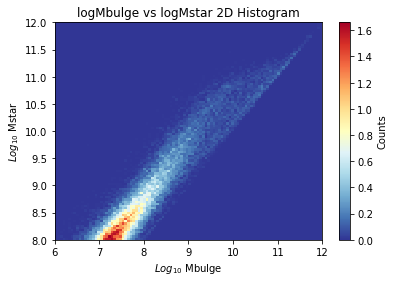

In [89]:
# Figure using the Matplotlib hist2d

plt.hist2d(df_not_normalized['GalpropLogMbulge'], df_not_normalized['GalpropLogMstar'], 
            bins=100, cmap ='RdYlBu_r', range=[[6.0,12.0],[8.0,12.0]], density=True) #cmap = plt.cm.jet) #, density=True)
plt.title('logMbulge vs logMstar 2D Histogram')
plt.ylabel('$ Log_{10} $ Mstar')
plt.xlabel('$ Log_{10} $ Mbulge')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
# plt.savefig("logMbulge_vs_logMstar_2D_Histogram.jpeg", dpi=500)
plt.show()

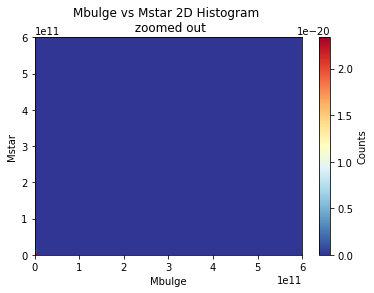

In [90]:
# Figure using the Matplotlib hist2d

plt.hist2d(df_not_normalized['GalpropMbulge'], df_not_normalized['GalpropMstar'], 
           range=[[0.0,6e11],[0.0,6e11]], cmap ='RdYlBu_r', bins=100, density=True)
plt.title('Mbulge vs Mstar 2D Histogram \n zoomed out')
plt.ylabel('Mstar')
plt.xlabel('Mbulge')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
# plt.savefig("Mbulge_vs_Mstar_2D_Histogram_zoomed_out.jpeg", dpi=500)
plt.show()

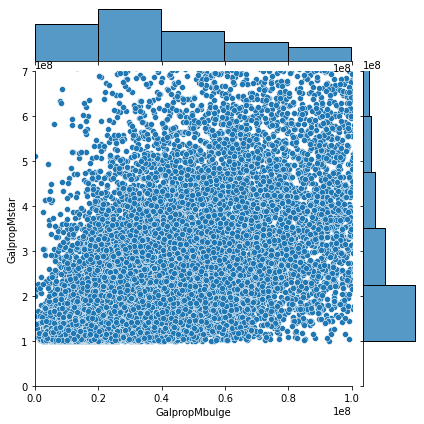

In [91]:
# df = sns.load_dataset('iris')
 
# Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
sns.jointplot(x=df_not_normalized['GalpropMbulge'], y=df_not_normalized['GalpropMstar'], 
              kind='scatter', xlim=(0.0,1e8), ylim=(0.0,7e8))
plt.show()

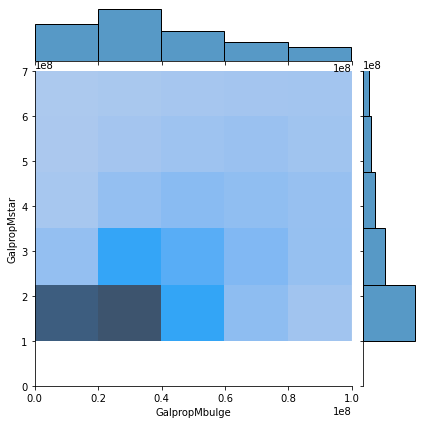

In [54]:
sns.jointplot(x=df_not_normalized['GalpropMbulge'], y=df_not_normalized['GalpropMstar'], 
              kind='hist', xlim=(0.0,1e8), ylim=(0.0,7e8))

plt.show()

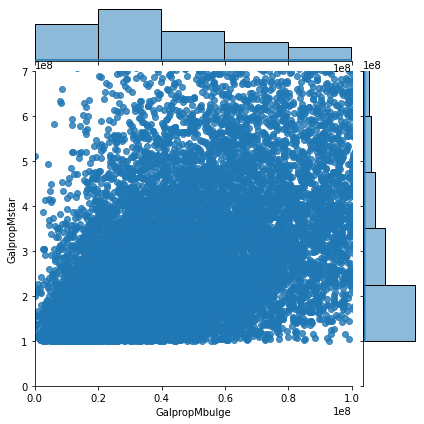

In [55]:
sns.jointplot(x=df_not_normalized['GalpropMbulge'], y=df_not_normalized['GalpropMstar'], 
              kind='reg', xlim=(0.0,1e8), ylim=(0.0,7e8))

plt.show()

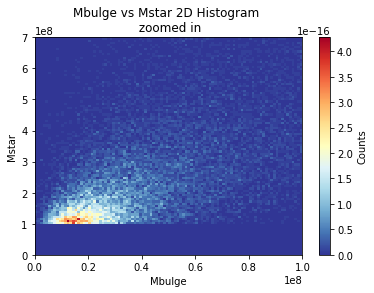

In [92]:
# Figure using the Matplotlib hist2d

plt.hist2d(df_not_normalized['GalpropMbulge'], df_not_normalized['GalpropMstar'], 
           range=[[0.0,1e8],[0.0,7e8]], cmap ='RdYlBu_r', bins=100, density=True)
plt.title('Mbulge vs Mstar 2D Histogram \n zoomed in')
plt.ylabel('Mstar')
plt.xlabel('Mbulge')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
# plt.savefig("Mbulge_vs_Mstar_2D_Histogram_zoomed_in.jpeg", dpi=500)
plt.show()

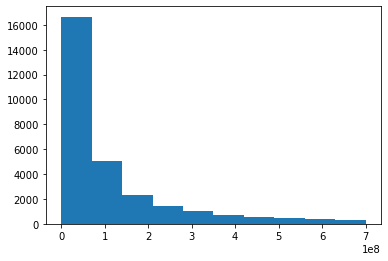

In [93]:
plt.hist(df_not_normalized['GalpropMbulge'], range=(0, 7e8))
plt.show()

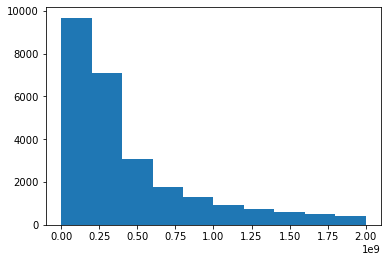

In [94]:
plt.hist(df_not_normalized['GalpropMstar'], range=(0, 2e9))
plt.show()

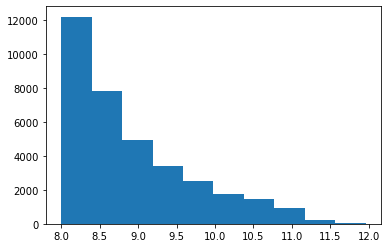

In [95]:
plt.hist(df_not_normalized['GalpropLogMstar'])
plt.show()

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


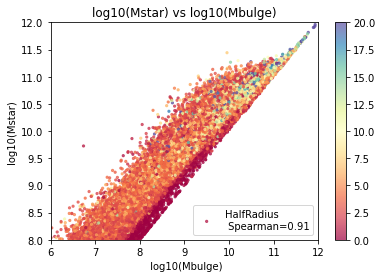

In [96]:
plt.scatter(np.log10(df_not_normalized.loc[:,'GalpropMbulge']), np.log10(df_not_normalized.loc[:, 'GalpropMstar']),
#             c = np.log10(df_not_normalized.loc[:,'GalpropMstar']),  cmap='Spectral',
            c = df_not_normalized.loc[:,'GalpropHalfRadius'],  cmap='Spectral',
            s=20, marker='.', alpha=0.7, label='HalfRadius \n Spearman=0.91', vmin=0.0, vmax=20)
# plt.plot([0.0, 6], [0.0, 120], color = 'black', linewidth = 2)
plt.xlim(6, 12)
plt.ylim(8, 12.0)
plt.xlabel(' log10(Mbulge)')
plt.ylabel('log10(Mstar)')
plt.title('log10(Mstar) vs log10(Mbulge)')
plt.legend(loc='lower right')
plt.colorbar()
# plt.savefig('log10Mstar_log10Mbulge.jpeg', dpi=500)
plt.show()

## <font color='darkred'> Correlations between Mbulge and Mstar by galaxy morphology

#### First remove the 22 non-physical galaxies, then
#### Define the 6 morphology groups by increasing Mbulge/Mstar ratio

In [143]:
# 7,865 galaxies in df_1
df_1 = dfnew3.loc[dfnew3.loc[:, 'BulgeMstar_ratio']<=0.10] 
df_1_raw = dfnew2.loc[dfnew2.loc[:, 'BulgeMstar_ratio']<=0.10] 


# 13,921 galaxies in df_2
df_2 = dfnew3.loc[(dfnew3.BulgeMstar_ratio > 0.10) & (dfnew3.BulgeMstar_ratio <= 0.20)] 
df_2_raw = dfnew2.loc[(dfnew2.BulgeMstar_ratio > 0.10) & (dfnew2.BulgeMstar_ratio <= 0.20)] 


# 6,880 galaxies in df_3
df_3 = dfnew3.loc[(dfnew3.BulgeMstar_ratio > 0.20) & (dfnew3.BulgeMstar_ratio <= 0.30)] 
df_3_raw = dfnew2.loc[(dfnew2.BulgeMstar_ratio > 0.20) & (dfnew2.BulgeMstar_ratio <= 0.30)] 


# 2,858 galaxies in df_4
df_4 = dfnew3.loc[(dfnew3.BulgeMstar_ratio > 0.30) & (dfnew3.BulgeMstar_ratio <= 0.40)] 
df_4_raw = dfnew2.loc[(dfnew2.BulgeMstar_ratio > 0.30) & (dfnew2.BulgeMstar_ratio <= 0.40)] 


# 1,444 galaxies in df_5
df_5 = dfnew3.loc[(dfnew3.BulgeMstar_ratio > 0.40) & (dfnew3.BulgeMstar_ratio <= 0.50)] 
df_5_raw = dfnew2.loc[(dfnew2.BulgeMstar_ratio > 0.40) & (dfnew2.BulgeMstar_ratio <= 0.50)] 


# 2,422 galaxies in df_5
df_6 = dfnew3.loc[dfnew3.loc[:, 'BulgeMstar_ratio']>0.50] 
df_6_raw = dfnew2.loc[dfnew2.loc[:, 'BulgeMstar_ratio']>0.50] 

# Combined morphologies 1 to 4 in order to fit one physical model to all of them; 31,524 galaxies in the 1-4 morphologies
df_14 = dfnew3.loc[dfnew3.BulgeMstar_ratio <= 0.40] #normalized
df_14_raw = dfnew2.loc[dfnew2.BulgeMstar_ratio <= 0.40] 


# Ellipticals only
df_56 = dfnew3.loc[dfnew3.BulgeMstar_ratio > 0.40] #normalized
df_56_raw = dfnew2.loc[dfnew2.BulgeMstar_ratio > 0.40]




#### Correlation between Mbulge and Mstar - not normalized

#### df_1

In [38]:
# df_1_raw 
# Pearson
np.corrcoef(df_1_raw.loc[:, 'GalpropMbulge'], df_1_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.93880844],
       [0.93880844, 1.        ]])

In [98]:
# df_1_raw without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
# Pearson
np.corrcoef(df_1_raw.loc[:, 'GalpropMbulge'], df_1_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.93880844],
       [0.93880844, 1.        ]])

In [39]:
# Spearman 
round(stats.spearmanr(df_1_raw.loc[:, 'GalpropMbulge'], df_1_raw.loc[:, 'GalpropMstar'])[0], 2)

0.97

In [99]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_1_raw.loc[:, 'GalpropMbulge'], df_1_raw.loc[:, 'GalpropMstar'])[0], 2)

0.97

#### df_2

In [40]:
# df_2_raw
# Pearson
np.corrcoef(df_2_raw.loc[:, 'GalpropMbulge'], df_2_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.98068058],
       [0.98068058, 1.        ]])

In [100]:
# df_2_raw without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
# Pearson
np.corrcoef(df_2_raw.loc[:, 'GalpropMbulge'], df_2_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.98068058],
       [0.98068058, 1.        ]])

In [41]:
# Spearman
round(stats.spearmanr(df_2_raw.loc[:, 'GalpropMbulge'], df_2_raw.loc[:, 'GalpropMstar'])[0], 2)

0.98

In [101]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_2_raw.loc[:, 'GalpropMbulge'], df_2_raw.loc[:, 'GalpropMstar'])[0], 2)

0.98

#### df_3

In [42]:
# df_3_raw
# Pearson
np.corrcoef(df_3_raw.loc[:, 'GalpropMbulge'], df_3_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.99189272],
       [0.99189272, 1.        ]])

In [102]:
# df_3_raw
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_3_raw.loc[:, 'GalpropMbulge'], df_3_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.99189272],
       [0.99189272, 1.        ]])

In [43]:
# Spearman
round(stats.spearmanr(df_3_raw.loc[:, 'GalpropMbulge'], df_3_raw.loc[:, 'GalpropMstar'])[0], 2)

0.99

In [103]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_3_raw.loc[:, 'GalpropMbulge'], df_3_raw.loc[:, 'GalpropMstar'])[0], 2)

0.99

#### df_4

In [44]:
# df_4_raw
# Pearson
np.corrcoef(df_4_raw.loc[:, 'GalpropMbulge'], df_4_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.99656685],
       [0.99656685, 1.        ]])

In [104]:
# df_4_raw
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_4_raw.loc[:, 'GalpropMbulge'], df_4_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.99656685],
       [0.99656685, 1.        ]])

In [45]:
# Spearman
round(stats.spearmanr(df_4_raw.loc[:, 'GalpropMbulge'], df_4_raw.loc[:, 'GalpropMstar'])[0], 2)

1.0

In [105]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_4_raw.loc[:, 'GalpropMbulge'], df_4_raw.loc[:, 'GalpropMstar'])[0], 2)

1.0

#### df_5

In [47]:
# df_5_raw
# Pearson
np.corrcoef(df_5_raw.loc[:, 'GalpropMbulge'], df_5_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.99736336],
       [0.99736336, 1.        ]])

In [106]:
# df_5_raw
# Pearson without 22 outlier galaxies; Pearson corr is the same as with 22 outliers up to 4 significant figures
np.corrcoef(df_5_raw.loc[:, 'GalpropMbulge'], df_5_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.99734489],
       [0.99734489, 1.        ]])

In [48]:
# Spearman
round(stats.spearmanr(df_5_raw.loc[:, 'GalpropMbulge'], df_5_raw.loc[:, 'GalpropMstar'])[0], 2)

1.0

In [107]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_5_raw.loc[:, 'GalpropMbulge'], df_5_raw.loc[:, 'GalpropMstar'])[0], 2)

1.0

#### df_6

In [49]:
# df_6_raw
# Pearson
np.corrcoef(df_6_raw.loc[:, 'GalpropMbulge'], df_6_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.98979992],
       [0.98979992, 1.        ]])

In [108]:
# df_1_raw
# Pearson without 22 outlier galaxies; Pearson corr is not the same, it goes from 0.99 to 0.94
np.corrcoef(df_1_raw.loc[:, 'GalpropMbulge'], df_1_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.93880844],
       [0.93880844, 1.        ]])

In [50]:
# Spearman 
round(stats.spearmanr(df_6_raw.loc[:, 'GalpropMbulge'], df_6_raw.loc[:, 'GalpropMstar'])[0], 2)

1.0

In [109]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_6_raw.loc[:, 'GalpropMbulge'], df_6_raw.loc[:, 'GalpropMstar'])[0], 2)

1.0

#### Combined morphologies 1 to 4 in order to fit one physical model to all of them

In [129]:
# Pearson
np.corrcoef(df_14_raw.loc[:, 'GalpropMbulge'], df_14_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.86459818],
       [0.86459818, 1.        ]])

In [144]:
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_14_raw.loc[:, 'GalpropMbulge'], df_14_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.86459818],
       [0.86459818, 1.        ]])

In [130]:
# Spearman
round(stats.spearmanr(df_14_raw.loc[:, 'GalpropMbulge'], df_14_raw.loc[:, 'GalpropMstar'])[0], 2)

0.91

In [145]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_14_raw.loc[:, 'GalpropMbulge'], df_14_raw.loc[:, 'GalpropMstar'])[0], 2)

0.91

#### Ellipticals only

In [132]:
# Pearson
np.corrcoef(df_56_raw.loc[:, 'GalpropMbulge'], df_56_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.98117355],
       [0.98117355, 1.        ]])

In [146]:
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_56_raw.loc[:, 'GalpropMbulge'], df_56_raw.loc[:, 'GalpropMstar'])

array([[1.        , 0.98127344],
       [0.98127344, 1.        ]])

In [133]:
# Spearman
round(stats.spearmanr(df_56_raw.loc[:, 'GalpropMbulge'], df_56_raw.loc[:, 'GalpropMstar'])[0], 2)

0.99

In [147]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_56_raw.loc[:, 'GalpropMbulge'], df_56_raw.loc[:, 'GalpropMstar'])[0], 2)

0.99

#### <font color='blue'> Correlation between Mbulge and Mstar - NORMALIZED

#### <font color='blue'> df_1

In [112]:
# df_1
# Pearson
np.corrcoef(df_1.loc[:, 'GalpropNormMbulge'], df_1.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.91842614],
       [0.91842614, 1.        ]])

In [148]:
# df_1
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_1.loc[:, 'GalpropNormMbulge'], df_1.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.91842614],
       [0.91842614, 1.        ]])

In [113]:
# Spearman
round(stats.spearmanr(df_1.loc[:, 'GalpropNormMbulge'], df_1.loc[:, 'GalpropNormMstar'])[0], 2)

0.93

In [149]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_1.loc[:, 'GalpropNormMbulge'], df_1.loc[:, 'GalpropNormMstar'])[0], 2)

0.93

#### <font color='blue'> df_2

In [114]:
# df_2
# Pearson
np.corrcoef(df_2.loc[:, 'GalpropNormMbulge'], df_2.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.97333151],
       [0.97333151, 1.        ]])

In [150]:
# df_2
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_2.loc[:, 'GalpropNormMbulge'], df_2.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.97333151],
       [0.97333151, 1.        ]])

In [115]:
# Spearman
round(stats.spearmanr(df_2.loc[:, 'GalpropNormMbulge'], df_2.loc[:, 'GalpropNormMstar'])[0], 2)

0.96

In [151]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_2.loc[:, 'GalpropNormMbulge'], df_2.loc[:, 'GalpropNormMstar'])[0], 2)

0.96

#### <font color='blue'> df_3

In [116]:
# df_3
# Pearson
np.corrcoef(df_3.loc[:, 'GalpropNormMbulge'], df_3.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.99016401],
       [0.99016401, 1.        ]])

In [152]:
# df_3
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_3.loc[:, 'GalpropNormMbulge'], df_3.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.99016401],
       [0.99016401, 1.        ]])

In [117]:
# Spearman
round(stats.spearmanr(df_3.loc[:, 'GalpropNormMbulge'], df_3.loc[:, 'GalpropNormMstar'])[0], 2)

0.98

In [153]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_3.loc[:, 'GalpropNormMbulge'], df_3.loc[:, 'GalpropNormMstar'])[0], 2)

0.98

#### <font color='blue'> df_4

In [118]:
# df_4
# Pearson
np.corrcoef(df_4.loc[:, 'GalpropNormMbulge'], df_4.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.99605722],
       [0.99605722, 1.        ]])

In [154]:
# df_4
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_4.loc[:, 'GalpropNormMbulge'], df_4.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.99605722],
       [0.99605722, 1.        ]])

In [119]:
# Spearman
round(stats.spearmanr(df_4.loc[:, 'GalpropNormMbulge'], df_4.loc[:, 'GalpropNormMstar'])[0], 2)

0.99

In [155]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_4.loc[:, 'GalpropNormMbulge'], df_4.loc[:, 'GalpropNormMstar'])[0], 2)

0.99

#### <font color='blue'> df_5

In [156]:
# df_5
# Pearson
np.corrcoef(df_5.loc[:, 'GalpropNormMbulge'], df_5.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.99743297],
       [0.99743297, 1.        ]])

In [ ]:
# df_5
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_5.loc[:, 'GalpropNormMbulge'], df_5.loc[:, 'GalpropNormMstar'])

In [121]:
# Spearman
round(stats.spearmanr(df_5.loc[:, 'GalpropNormMbulge'], df_5.loc[:, 'GalpropNormMstar'])[0], 2)

1.0

In [157]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_5.loc[:, 'GalpropNormMbulge'], df_5.loc[:, 'GalpropNormMstar'])[0], 2)

1.0

#### <font color='blue'> df_6

In [123]:
# df_6
# Pearson
np.corrcoef(df_6.loc[:, 'GalpropNormMbulge'], df_6.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.99934561],
       [0.99934561, 1.        ]])

In [158]:
# df_6
# Pearson without 22 outlier galaxies; Pearson corr goes from 1.0 to 0.97
np.corrcoef(df_6.loc[:, 'GalpropNormMbulge'], df_6.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.97189236],
       [0.97189236, 1.        ]])

In [124]:
# Spearman
round(stats.spearmanr(df_6.loc[:, 'GalpropNormMbulge'], df_6.loc[:, 'GalpropNormMstar'])[0], 2)

0.98

In [159]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_6.loc[:, 'GalpropNormMbulge'], df_6.loc[:, 'GalpropNormMstar'])[0], 2)

0.98

#### <font color='blue'> Combined morphologies 1 to 4 in order to fit one physical model to all of them

In [125]:
# Pearson
np.corrcoef(df_14.loc[:, 'GalpropNormMbulge'], df_14.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.80711151],
       [0.80711151, 1.        ]])

In [160]:
# Pearson without 22 outlier galaxies; Pearson corr is exaclty same as with 22 outliers
np.corrcoef(df_14.loc[:, 'GalpropNormMbulge'], df_14.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.80711151],
       [0.80711151, 1.        ]])

In [126]:
# Spearman
round(stats.spearmanr(df_14.loc[:, 'GalpropNormMbulge'], df_14.loc[:, 'GalpropNormMstar'])[0], 2)

0.78

In [161]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_14.loc[:, 'GalpropNormMbulge'], df_14.loc[:, 'GalpropNormMstar'])[0], 2)

0.78

#### <font color='blue'> Ellipticals only

In [134]:
# Pearson
np.corrcoef(df_56.loc[:, 'GalpropNormMbulge'], df_56.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.99886016],
       [0.99886016, 1.        ]])

In [162]:
# Pearson without 22 outlier galaxies; Pearson corr goes from 1.0 to 0.96
np.corrcoef(df_56.loc[:, 'GalpropNormMbulge'], df_56.loc[:, 'GalpropNormMstar'])

array([[1.        , 0.95703939],
       [0.95703939, 1.        ]])

In [135]:
# Spearman
round(stats.spearmanr(df_56.loc[:, 'GalpropNormMbulge'], df_56.loc[:, 'GalpropNormMstar'])[0], 2)

0.97

In [163]:
# Spearman without 22 outlier galaxies; Spearman corr is exaclty same as with 22 outliers
round(stats.spearmanr(df_56.loc[:, 'GalpropNormMbulge'], df_56.loc[:, 'GalpropNormMstar'])[0], 2)

0.97